<a href="https://colab.research.google.com/github/Mfys212/GNN-for-Molekul-Classifier/blob/main/GNN_Molekul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch_geometric
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 32.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import torch
from torch import nn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as DL_geo
from torch_geometric.nn import GCNConv, global_mean_pool, GINEConv
from torch.utils.data import DataLoader, TensorDataset
from rdkit import Chem
from rdkit.Chem import rdmolops, AllChem
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
import random
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import concurrent.futures
from tqdm import tqdm

In [3]:
df_2class_prep = pd.read_csv('https://raw.githubusercontent.com/Mfys212/dokumen/refs/heads/main/01_label2class_sars.csv')
df_2class_prep

,molecule_chembl_id,class,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL541133,active,Cc1ccc([N+](=O)[O-])cc1S(=O)(=O)c1nc(-c2cnc3cc...,434.886,4.16062,0.0,8.0,7.000000
1,CHEMBL538346,active,Oc1cccc(-c2nc(N3CCOCC3)c3oc4ncccc4c3n2)c1,348.362,2.98020,1.0,7.0,8.000000
2,CHEMBL541643,active,Oc1cccc(-c2nc(N3CCOCC3)c3sccc3n2)c1,313.382,2.90050,1.0,6.0,6.657577
3,CHEMBL556399,active,Cc1ccc([N+](=O)[O-])cc1S(=O)(=O)N(C)/N=C/c1cnc...,452.290,2.96802,0.0,7.0,7.000000
4,CHEMBL538346,active,Oc1cccc(-c2nc(N3CCOCC3)c3oc4ncccc4c3n2)c1,348.362,2.98020,1.0,7.0,8.000000
...,...,...,...,...,...,...,...,...
5805,CHEMBL5279152,active,CCn1c(=O)c2ccnn2c2cc(N)c(C(=O)NCc3cccnc3)cc21,362.393,1.57630,2.0,7.0,6.060481
5806,CHEMBL5269677,active,CCn1c(=O)c2ccnn2c2cc(N)c(C(=O)NCc3cncnc3)cc21,363.381,0.97130,2.0,8.0,6.619789
5807,CHEMBL5279774,inactive,CCn1c(=O)c2ccnn2c2cc(NC)c(C(=O)NCc3cccnc3)cc21,376.420,2.03580,2.0,7.0,4.698970
5808,CHEMBL5271447,inactive,CCn1c(=O)c2ccnn2c2cc(N(C)C)c(C(=O)NCc3cccnc3)cc21,390.447,2.06010,1.0,7.0,4.698970


In [4]:
data = df_2class_prep[["canonical_smiles", "class"]]
print(data.isnull().sum(), "\n")
data.info()

canonical_smiles    0
class               0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5810 entries, 0 to 5809
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   canonical_smiles  5810 non-null   object
 1   class             5810 non-null   object
dtypes: object(2)
memory usage: 90.9+ KB


In [5]:
class_counts = data["class"].value_counts()
class_counts

,count
class,
active,4846
inactive,964


In [6]:
target_data = 2500
ros = RandomOverSampler(random_state=42)
run = RandomUnderSampler(sampling_strategy={'active': target_data}, random_state=42)
X_resampled, y_resampled = run.fit_resample(data[['canonical_smiles']], data['class'])
X_resampled, y_resampled = ros.fit_resample(X_resampled, y_resampled)

df_final = pd.DataFrame({
    'canonical_smiles': X_resampled['canonical_smiles'],
    'class': y_resampled
})

In [7]:
print(df_final.info(), "\n")
df_final['class'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   canonical_smiles  5000 non-null   object
 1   class             5000 non-null   object
dtypes: object(2)
memory usage: 78.2+ KB
None 



,count
class,
active,2500
inactive,2500


In [8]:
class LoaderData(nn.Module):
    def __init__(self, X, y, batch=32, test_size=0.2, seed=212):
        super().__init__()
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, random_state=seed)
        self.batch_size = batch
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

    def process_molecule(self, molecule, cls):
        return self.molecule_to_graph(molecule, cls)

    def forward(self):
        with concurrent.futures.ThreadPoolExecutor() as executor:
            train_graphs = list(executor.map(self.process_molecule, self.X_train, self.y_train))
            val_graphs = list(executor.map(self.process_molecule, self.X_test, self.y_test))

        train_loader = DL_geo(train_graphs, batch_size=self.batch_size, shuffle=True)
        val_loader = DL_geo(val_graphs, batch_size=self.batch_size, shuffle=False)
        return train_loader, val_loader

    def molecule_to_graph(self, molecule: str, y=None, use_y=True):
        mol = Chem.MolFromSmiles(molecule)
        if mol is None:
            return None

        atoms = [
            [
                atom.GetAtomicNum(),              # Nomor atom
                atom.GetMass(),                   # Massa atom
                int(atom.GetIsAromatic()),        # Apakah atom aromatik
                int(atom.GetHybridization()),     # Tipe hibridisasi
                atom.GetFormalCharge(),           # Muatan formal
                atom.GetDegree(),                 # Derajat atom
                atom.GetImplicitValence(),        # Valensi implisit
                atom.GetExplicitValence(),        # Valensi eksplisit
                int(atom.IsInRing()),             # Apakah dalam cincin
                int(atom.GetChiralTag()),         # Tag kiralitas
            ]
            for atom in mol.GetAtoms()
        ]

        edges = []
        edge_attr = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edges.append([i, j])
            edges.append([j, i])  # kedua arah untuk graf tak berarah

            bond_features = [
                bond.GetBondTypeAsDouble(),      # Tipe ikatan
                int(bond.GetIsConjugated()),     # Apakah ikatan terkonjugasi
                int(bond.GetIsAromatic()),       # Apakah ikatan aromatik
                int(bond.GetStereo()),           # Stereokimia ikatan
                int(bond.IsInRing()),            # Apakah ikatan dalam cincin
            ]
            edge_attr.append(bond_features)
            edge_attr.append(bond_features) # fitur edge untuk arah sebaliknya

        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
        x = torch.tensor(atoms, dtype=torch.float)

        if use_y:
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=torch.tensor([y], dtype=torch.long))
        else:
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        return data

class GNNBlock(nn.Module):
    def __init__(self, edge_features, c1, c2, dropout_rate=0.3):
        super().__init__()
        self.conv1 = GINEConv(nn.Linear(c1, c2), edge_dim=edge_features)
        self.conv2 = GINEConv(nn.Linear(c2, c1), edge_dim=edge_features)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, inputs, edge_index, edge_attr):
        x = self.dropout(F.leaky_relu(self.conv1(inputs, edge_index, edge_attr)))
        return self.conv2(x+inputs, edge_index, edge_attr)

class GNNModel(nn.Module):
    def __init__(self, num_features, edge_features, c1=128, c2=128, num_block=2):
        super().__init__()
        self.inputs = GINEConv(nn.Linear(num_features, c1), edge_dim=edge_features)
        self.block = [GNNBlock(edge_features, c1, c2) for i in range(num_block)]
        self.cls = nn.Linear(c1, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.inputs(x, edge_index, edge_attr)
        for block in self.block:
            x = block(x, edge_index, edge_attr)
        x = global_mean_pool(self.cls(x), data.batch)
        return x

class CreateModel(nn.Module):
    def __init__(self,
                 X, y,
                 epochs,
                 batch=32,
                 test_size=0.2,
                 seed=212,
                 c1=128,
                 c2=128,
                 num_block=2,
                 dropout_rate=0.3):
        super().__init__()
        self.epochs = epochs
        self.loader = LoaderData(X, y, batch, test_size, seed)
        self.train_loader, self.val_loader = self.loader()
        self.num_node_features = self.train_loader.dataset[0].x.size(1)
        self.num_edge_features = self.train_loader.dataset[0].edge_attr.size(1)
        self.model = GNNModel(self.num_node_features, self.num_edge_features, c1, c2, num_block)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = self.model.to(self.device)

    def train(self, optimizer, criterion):
        self.model.train()
        total_loss = 0
        correct = 0
        with tqdm(self.train_loader, desc="Training", unit="batch") as t:
            for data in t:
                data = data.to(self.device)
                optimizer.zero_grad()
                out = self.model(data)
                loss = criterion(out.view(-1), data.y.float())
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                pred = torch.sigmoid(out)
                pred = (pred > 0.5).float()
                correct += (pred.view(-1) == data.y).sum().item()
        avg_loss = total_loss / len(self.train_loader)
        accuracy = correct / len(self.train_loader.dataset)
        return avg_loss, accuracy

    def validate(self, criterion):
        self.model.eval()
        total_loss = 0
        correct = 0
        with tqdm(self.val_loader, desc="Validation", unit="batch") as t:
            with torch.no_grad():
                for data in t:
                    data = data.to(self.device)
                    out = self.model(data)
                    loss = criterion(out.view(-1), data.y.float())
                    total_loss += loss.item()
                    pred = torch.sigmoid(out)
                    pred = (pred > 0.5).float()
                    correct += (pred.view(-1) == data.y).sum().item()
        avg_loss = total_loss / len(self.val_loader)
        accuracy = correct / len(self.val_loader.dataset)
        return avg_loss, accuracy

    def fit(self):
        optimizer, criterion = self.get_optim()
        train_losses, val_losses, val_accuracies = [], [], []
        t_acc, t_loss, v_acc, v_loss = [], [], [], []
        for epoch in range(1, self.epochs + 1):
            train_loss, train_acc = self.train(optimizer, criterion)
            train_losses.append(train_loss)
            val_loss, val_accuracy = self.validate(criterion)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            print(f"Epoch {epoch}/{self.epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}\n")
            t_loss.append(train_loss)
            t_acc.append(train_acc)
            v_loss.append(val_loss)
            v_acc.append(val_accuracy)
        history = {"Train Loss":t_loss, "Train Acc":t_acc, "Val Loss":v_loss, "Val Acc":v_acc}
        return history

    def get_optim(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001, weight_decay=1e-5)
        criterion = nn.BCEWithLogitsLoss()
        return optimizer, criterion

In [9]:
X = df_final['canonical_smiles']
y = df_final['class'].map({'active': 1, 'inactive': 0})
EPOCHS = 100
model = CreateModel(X, y, epochs=EPOCHS, batch=32, test_size=0.2, seed=212)

In [10]:
history = model.fit()

Validation: 100%|██████████| 32/32 [00:02<00:00, 15.15batch/s]


Epoch 1/100 | Train Loss: 3.2159 | Train Acc: 0.5118 | Val Loss: 1.4745 | Val Acc: 0.5210



Validation: 100%|██████████| 32/32 [00:00<00:00, 78.55batch/s]


Epoch 2/100 | Train Loss: 1.2347 | Train Acc: 0.5110 | Val Loss: 1.0714 | Val Acc: 0.5420



Validation: 100%|██████████| 32/32 [00:00<00:00, 59.50batch/s]


Epoch 3/100 | Train Loss: 0.9900 | Train Acc: 0.5192 | Val Loss: 0.9107 | Val Acc: 0.5320



Validation: 100%|██████████| 32/32 [00:00<00:00, 71.00batch/s]


Epoch 4/100 | Train Loss: 0.8763 | Train Acc: 0.5280 | Val Loss: 0.8075 | Val Acc: 0.5250



Validation: 100%|██████████| 32/32 [00:00<00:00, 73.67batch/s]


Epoch 5/100 | Train Loss: 0.7914 | Train Acc: 0.5367 | Val Loss: 0.8441 | Val Acc: 0.4960



Validation: 100%|██████████| 32/32 [00:00<00:00, 76.02batch/s]


Epoch 6/100 | Train Loss: 0.8524 | Train Acc: 0.5162 | Val Loss: 0.7326 | Val Acc: 0.5230



Validation: 100%|██████████| 32/32 [00:00<00:00, 75.63batch/s]


Epoch 7/100 | Train Loss: 0.7543 | Train Acc: 0.5355 | Val Loss: 0.7265 | Val Acc: 0.5380



Validation: 100%|██████████| 32/32 [00:00<00:00, 74.46batch/s]


Epoch 8/100 | Train Loss: 0.7338 | Train Acc: 0.5340 | Val Loss: 0.7068 | Val Acc: 0.5670



Validation: 100%|██████████| 32/32 [00:00<00:00, 79.27batch/s]


Epoch 9/100 | Train Loss: 0.7412 | Train Acc: 0.5433 | Val Loss: 0.7055 | Val Acc: 0.5650



Validation: 100%|██████████| 32/32 [00:00<00:00, 53.09batch/s]


Epoch 10/100 | Train Loss: 0.7033 | Train Acc: 0.5557 | Val Loss: 0.7062 | Val Acc: 0.5310



Validation: 100%|██████████| 32/32 [00:00<00:00, 76.34batch/s]


Epoch 11/100 | Train Loss: 0.7003 | Train Acc: 0.5623 | Val Loss: 0.6944 | Val Acc: 0.5320



Validation: 100%|██████████| 32/32 [00:00<00:00, 74.20batch/s]


Epoch 12/100 | Train Loss: 0.7402 | Train Acc: 0.5443 | Val Loss: 0.7768 | Val Acc: 0.5020



Validation: 100%|██████████| 32/32 [00:00<00:00, 50.23batch/s]


Epoch 13/100 | Train Loss: 0.7187 | Train Acc: 0.5577 | Val Loss: 0.9283 | Val Acc: 0.5010



Validation: 100%|██████████| 32/32 [00:00<00:00, 77.81batch/s]


Epoch 14/100 | Train Loss: 0.7220 | Train Acc: 0.5505 | Val Loss: 0.6667 | Val Acc: 0.6010



Validation: 100%|██████████| 32/32 [00:00<00:00, 79.63batch/s]


Epoch 15/100 | Train Loss: 0.6928 | Train Acc: 0.5640 | Val Loss: 0.6878 | Val Acc: 0.5760



Validation: 100%|██████████| 32/32 [00:00<00:00, 55.48batch/s]


Epoch 16/100 | Train Loss: 0.6939 | Train Acc: 0.5613 | Val Loss: 0.6744 | Val Acc: 0.6130



Validation: 100%|██████████| 32/32 [00:00<00:00, 72.33batch/s]


Epoch 17/100 | Train Loss: 0.6801 | Train Acc: 0.5817 | Val Loss: 0.6920 | Val Acc: 0.6050



Validation: 100%|██████████| 32/32 [00:00<00:00, 74.61batch/s]


Epoch 18/100 | Train Loss: 0.7113 | Train Acc: 0.5523 | Val Loss: 0.9021 | Val Acc: 0.5020



Validation: 100%|██████████| 32/32 [00:00<00:00, 71.28batch/s]


Epoch 19/100 | Train Loss: 0.7075 | Train Acc: 0.5493 | Val Loss: 0.6674 | Val Acc: 0.5710



Validation: 100%|██████████| 32/32 [00:00<00:00, 72.32batch/s]


Epoch 20/100 | Train Loss: 0.6923 | Train Acc: 0.5673 | Val Loss: 1.0387 | Val Acc: 0.5000



Validation: 100%|██████████| 32/32 [00:00<00:00, 72.96batch/s]


Epoch 21/100 | Train Loss: 0.7201 | Train Acc: 0.5570 | Val Loss: 0.7050 | Val Acc: 0.5660



Validation: 100%|██████████| 32/32 [00:00<00:00, 77.77batch/s]


Epoch 22/100 | Train Loss: 0.6834 | Train Acc: 0.5777 | Val Loss: 0.6849 | Val Acc: 0.5890



Validation: 100%|██████████| 32/32 [00:00<00:00, 73.24batch/s]


Epoch 23/100 | Train Loss: 0.7020 | Train Acc: 0.5607 | Val Loss: 0.7187 | Val Acc: 0.5010



Validation: 100%|██████████| 32/32 [00:00<00:00, 75.59batch/s]


Epoch 24/100 | Train Loss: 0.6748 | Train Acc: 0.5867 | Val Loss: 0.7726 | Val Acc: 0.4990



Validation: 100%|██████████| 32/32 [00:00<00:00, 76.62batch/s]


Epoch 25/100 | Train Loss: 0.6949 | Train Acc: 0.5663 | Val Loss: 0.6455 | Val Acc: 0.6160



Validation: 100%|██████████| 32/32 [00:00<00:00, 79.10batch/s]


Epoch 26/100 | Train Loss: 0.6626 | Train Acc: 0.6045 | Val Loss: 0.7043 | Val Acc: 0.5970



Validation: 100%|██████████| 32/32 [00:00<00:00, 73.64batch/s]


Epoch 27/100 | Train Loss: 0.6784 | Train Acc: 0.5910 | Val Loss: 0.6382 | Val Acc: 0.6330



Validation: 100%|██████████| 32/32 [00:00<00:00, 77.09batch/s]


Epoch 28/100 | Train Loss: 0.6733 | Train Acc: 0.6032 | Val Loss: 0.6486 | Val Acc: 0.6520



Validation: 100%|██████████| 32/32 [00:00<00:00, 67.71batch/s]


Epoch 29/100 | Train Loss: 0.6602 | Train Acc: 0.6045 | Val Loss: 0.6614 | Val Acc: 0.6250



Validation: 100%|██████████| 32/32 [00:00<00:00, 74.13batch/s]


Epoch 30/100 | Train Loss: 0.6589 | Train Acc: 0.6085 | Val Loss: 0.6528 | Val Acc: 0.6450



Validation: 100%|██████████| 32/32 [00:00<00:00, 72.31batch/s]


Epoch 31/100 | Train Loss: 0.6557 | Train Acc: 0.6038 | Val Loss: 0.6596 | Val Acc: 0.6020



Validation: 100%|██████████| 32/32 [00:00<00:00, 48.37batch/s]


Epoch 32/100 | Train Loss: 0.6730 | Train Acc: 0.5905 | Val Loss: 0.6389 | Val Acc: 0.6310



Validation: 100%|██████████| 32/32 [00:00<00:00, 72.32batch/s]


Epoch 33/100 | Train Loss: 0.6581 | Train Acc: 0.6168 | Val Loss: 0.6811 | Val Acc: 0.5490



Validation: 100%|██████████| 32/32 [00:00<00:00, 77.97batch/s]


Epoch 34/100 | Train Loss: 0.6545 | Train Acc: 0.6198 | Val Loss: 0.6513 | Val Acc: 0.5990



Validation: 100%|██████████| 32/32 [00:00<00:00, 52.36batch/s]


Epoch 35/100 | Train Loss: 0.6492 | Train Acc: 0.6262 | Val Loss: 0.6922 | Val Acc: 0.6010



Validation: 100%|██████████| 32/32 [00:00<00:00, 75.12batch/s]


Epoch 36/100 | Train Loss: 0.6474 | Train Acc: 0.6272 | Val Loss: 0.6598 | Val Acc: 0.5710



Validation: 100%|██████████| 32/32 [00:00<00:00, 80.54batch/s]


Epoch 37/100 | Train Loss: 0.6633 | Train Acc: 0.6198 | Val Loss: 0.6469 | Val Acc: 0.6370



Validation: 100%|██████████| 32/32 [00:00<00:00, 50.41batch/s]


Epoch 38/100 | Train Loss: 0.6492 | Train Acc: 0.6295 | Val Loss: 0.6355 | Val Acc: 0.6630



Validation: 100%|██████████| 32/32 [00:00<00:00, 77.91batch/s]


Epoch 39/100 | Train Loss: 0.6421 | Train Acc: 0.6270 | Val Loss: 0.6305 | Val Acc: 0.6550



Validation: 100%|██████████| 32/32 [00:00<00:00, 74.65batch/s]


Epoch 40/100 | Train Loss: 0.6581 | Train Acc: 0.6158 | Val Loss: 0.6355 | Val Acc: 0.6430



Validation: 100%|██████████| 32/32 [00:00<00:00, 60.32batch/s]


Epoch 41/100 | Train Loss: 0.6501 | Train Acc: 0.6232 | Val Loss: 0.6180 | Val Acc: 0.6560



Validation: 100%|██████████| 32/32 [00:00<00:00, 77.37batch/s]


Epoch 42/100 | Train Loss: 0.6707 | Train Acc: 0.6050 | Val Loss: 0.6373 | Val Acc: 0.6000



Validation: 100%|██████████| 32/32 [00:00<00:00, 70.26batch/s]


Epoch 43/100 | Train Loss: 0.6532 | Train Acc: 0.6128 | Val Loss: 0.6236 | Val Acc: 0.6600



Validation: 100%|██████████| 32/32 [00:00<00:00, 75.59batch/s]


Epoch 44/100 | Train Loss: 0.6468 | Train Acc: 0.6275 | Val Loss: 0.6588 | Val Acc: 0.5940



Validation: 100%|██████████| 32/32 [00:00<00:00, 76.21batch/s]


Epoch 45/100 | Train Loss: 0.6402 | Train Acc: 0.6365 | Val Loss: 0.6394 | Val Acc: 0.6410



Validation: 100%|██████████| 32/32 [00:00<00:00, 76.39batch/s]


Epoch 46/100 | Train Loss: 0.6328 | Train Acc: 0.6415 | Val Loss: 0.6376 | Val Acc: 0.6410



Validation: 100%|██████████| 32/32 [00:00<00:00, 75.04batch/s]


Epoch 47/100 | Train Loss: 0.6528 | Train Acc: 0.6248 | Val Loss: 0.6243 | Val Acc: 0.6510



Validation: 100%|██████████| 32/32 [00:00<00:00, 61.99batch/s]


Epoch 48/100 | Train Loss: 0.6329 | Train Acc: 0.6508 | Val Loss: 0.6104 | Val Acc: 0.6750



Validation: 100%|██████████| 32/32 [00:00<00:00, 73.42batch/s]


Epoch 49/100 | Train Loss: 0.6368 | Train Acc: 0.6398 | Val Loss: 0.6204 | Val Acc: 0.6530



Validation: 100%|██████████| 32/32 [00:00<00:00, 76.44batch/s]


Epoch 50/100 | Train Loss: 0.6619 | Train Acc: 0.6138 | Val Loss: 0.6177 | Val Acc: 0.6650



Validation: 100%|██████████| 32/32 [00:00<00:00, 47.93batch/s]


Epoch 51/100 | Train Loss: 0.6269 | Train Acc: 0.6490 | Val Loss: 0.6226 | Val Acc: 0.6400



Validation: 100%|██████████| 32/32 [00:00<00:00, 75.39batch/s]


Epoch 52/100 | Train Loss: 0.6321 | Train Acc: 0.6488 | Val Loss: 0.6136 | Val Acc: 0.6700



Validation: 100%|██████████| 32/32 [00:00<00:00, 75.62batch/s]


Epoch 53/100 | Train Loss: 0.6340 | Train Acc: 0.6518 | Val Loss: 0.6052 | Val Acc: 0.6630



Validation: 100%|██████████| 32/32 [00:00<00:00, 53.49batch/s]


Epoch 54/100 | Train Loss: 0.6384 | Train Acc: 0.6452 | Val Loss: 0.6175 | Val Acc: 0.6610



Validation: 100%|██████████| 32/32 [00:00<00:00, 76.55batch/s]


Epoch 55/100 | Train Loss: 0.6411 | Train Acc: 0.6282 | Val Loss: 0.6214 | Val Acc: 0.6610



Validation: 100%|██████████| 32/32 [00:00<00:00, 79.78batch/s]


Epoch 56/100 | Train Loss: 0.6269 | Train Acc: 0.6465 | Val Loss: 0.6216 | Val Acc: 0.6480



Validation: 100%|██████████| 32/32 [00:00<00:00, 70.63batch/s]


Epoch 57/100 | Train Loss: 0.6337 | Train Acc: 0.6362 | Val Loss: 0.6282 | Val Acc: 0.6360



Validation: 100%|██████████| 32/32 [00:00<00:00, 71.01batch/s]


Epoch 58/100 | Train Loss: 0.6405 | Train Acc: 0.6365 | Val Loss: 0.6431 | Val Acc: 0.6330



Validation: 100%|██████████| 32/32 [00:00<00:00, 75.74batch/s]


Epoch 59/100 | Train Loss: 0.6224 | Train Acc: 0.6607 | Val Loss: 0.6166 | Val Acc: 0.6560



Validation: 100%|██████████| 32/32 [00:00<00:00, 75.82batch/s]


Epoch 60/100 | Train Loss: 0.6375 | Train Acc: 0.6402 | Val Loss: 0.6278 | Val Acc: 0.6530



Validation: 100%|██████████| 32/32 [00:00<00:00, 72.16batch/s]


Epoch 61/100 | Train Loss: 0.6482 | Train Acc: 0.6260 | Val Loss: 0.6600 | Val Acc: 0.6310



Validation: 100%|██████████| 32/32 [00:00<00:00, 79.31batch/s]


Epoch 62/100 | Train Loss: 0.6268 | Train Acc: 0.6448 | Val Loss: 0.6160 | Val Acc: 0.6410



Validation: 100%|██████████| 32/32 [00:00<00:00, 77.95batch/s]


Epoch 63/100 | Train Loss: 0.6201 | Train Acc: 0.6623 | Val Loss: 0.6162 | Val Acc: 0.6600



Validation: 100%|██████████| 32/32 [00:00<00:00, 51.68batch/s]


Epoch 64/100 | Train Loss: 0.6326 | Train Acc: 0.6382 | Val Loss: 0.6113 | Val Acc: 0.6690



Validation: 100%|██████████| 32/32 [00:00<00:00, 73.07batch/s]


Epoch 65/100 | Train Loss: 0.6171 | Train Acc: 0.6558 | Val Loss: 0.6466 | Val Acc: 0.6140



Validation: 100%|██████████| 32/32 [00:00<00:00, 74.84batch/s]


Epoch 66/100 | Train Loss: 0.6243 | Train Acc: 0.6480 | Val Loss: 0.5895 | Val Acc: 0.6930



Validation: 100%|██████████| 32/32 [00:00<00:00, 56.49batch/s]


Epoch 67/100 | Train Loss: 0.6313 | Train Acc: 0.6420 | Val Loss: 0.6091 | Val Acc: 0.6630



Validation: 100%|██████████| 32/32 [00:00<00:00, 74.23batch/s]


Epoch 68/100 | Train Loss: 0.6322 | Train Acc: 0.6458 | Val Loss: 0.5959 | Val Acc: 0.6850



Validation: 100%|██████████| 32/32 [00:00<00:00, 74.26batch/s]


Epoch 69/100 | Train Loss: 0.6426 | Train Acc: 0.6322 | Val Loss: 0.5985 | Val Acc: 0.6800



Validation: 100%|██████████| 32/32 [00:00<00:00, 64.24batch/s]


Epoch 70/100 | Train Loss: 0.6217 | Train Acc: 0.6520 | Val Loss: 0.6489 | Val Acc: 0.5920



Validation: 100%|██████████| 32/32 [00:00<00:00, 72.55batch/s]


Epoch 71/100 | Train Loss: 0.6221 | Train Acc: 0.6498 | Val Loss: 0.6104 | Val Acc: 0.6490



Validation: 100%|██████████| 32/32 [00:00<00:00, 70.82batch/s]


Epoch 72/100 | Train Loss: 0.6230 | Train Acc: 0.6498 | Val Loss: 0.6049 | Val Acc: 0.6690



Validation: 100%|██████████| 32/32 [00:00<00:00, 71.81batch/s]


Epoch 73/100 | Train Loss: 0.6213 | Train Acc: 0.6438 | Val Loss: 0.6017 | Val Acc: 0.6690



Validation: 100%|██████████| 32/32 [00:00<00:00, 72.31batch/s]


Epoch 74/100 | Train Loss: 0.6259 | Train Acc: 0.6482 | Val Loss: 0.6108 | Val Acc: 0.6740



Validation: 100%|██████████| 32/32 [00:00<00:00, 79.19batch/s]


Epoch 75/100 | Train Loss: 0.6210 | Train Acc: 0.6545 | Val Loss: 0.5989 | Val Acc: 0.6790



Validation: 100%|██████████| 32/32 [00:00<00:00, 78.73batch/s]


Epoch 76/100 | Train Loss: 0.6172 | Train Acc: 0.6542 | Val Loss: 0.6005 | Val Acc: 0.6650



Validation: 100%|██████████| 32/32 [00:00<00:00, 50.53batch/s]


Epoch 77/100 | Train Loss: 0.6209 | Train Acc: 0.6552 | Val Loss: 0.6129 | Val Acc: 0.6600



Validation: 100%|██████████| 32/32 [00:00<00:00, 77.81batch/s]


Epoch 78/100 | Train Loss: 0.6129 | Train Acc: 0.6567 | Val Loss: 0.6018 | Val Acc: 0.6610



Validation: 100%|██████████| 32/32 [00:00<00:00, 74.96batch/s]


Epoch 79/100 | Train Loss: 0.6536 | Train Acc: 0.6182 | Val Loss: 0.6678 | Val Acc: 0.6300



Validation: 100%|██████████| 32/32 [00:00<00:00, 53.51batch/s]


Epoch 80/100 | Train Loss: 0.6216 | Train Acc: 0.6512 | Val Loss: 0.6963 | Val Acc: 0.6030



Validation: 100%|██████████| 32/32 [00:00<00:00, 79.90batch/s]


Epoch 81/100 | Train Loss: 0.6174 | Train Acc: 0.6528 | Val Loss: 0.5861 | Val Acc: 0.6950



Validation: 100%|██████████| 32/32 [00:00<00:00, 72.34batch/s]


Epoch 82/100 | Train Loss: 0.6263 | Train Acc: 0.6515 | Val Loss: 0.6821 | Val Acc: 0.6140



Validation: 100%|██████████| 32/32 [00:00<00:00, 71.55batch/s]


Epoch 83/100 | Train Loss: 0.6414 | Train Acc: 0.6320 | Val Loss: 0.5986 | Val Acc: 0.6650



Validation: 100%|██████████| 32/32 [00:00<00:00, 73.50batch/s]


Epoch 84/100 | Train Loss: 0.6166 | Train Acc: 0.6610 | Val Loss: 0.6118 | Val Acc: 0.6410



Validation: 100%|██████████| 32/32 [00:00<00:00, 74.78batch/s]


Epoch 85/100 | Train Loss: 0.6331 | Train Acc: 0.6480 | Val Loss: 0.6219 | Val Acc: 0.6590



Validation: 100%|██████████| 32/32 [00:00<00:00, 73.36batch/s]


Epoch 86/100 | Train Loss: 0.6143 | Train Acc: 0.6640 | Val Loss: 0.6035 | Val Acc: 0.6560



Validation: 100%|██████████| 32/32 [00:00<00:00, 60.71batch/s]


Epoch 87/100 | Train Loss: 0.6171 | Train Acc: 0.6535 | Val Loss: 0.6888 | Val Acc: 0.6180



Validation: 100%|██████████| 32/32 [00:00<00:00, 73.91batch/s]


Epoch 88/100 | Train Loss: 0.6051 | Train Acc: 0.6665 | Val Loss: 0.6076 | Val Acc: 0.6530



Validation: 100%|██████████| 32/32 [00:00<00:00, 55.39batch/s]


Epoch 89/100 | Train Loss: 0.6288 | Train Acc: 0.6368 | Val Loss: 0.6420 | Val Acc: 0.6220



Validation: 100%|██████████| 32/32 [00:00<00:00, 69.46batch/s]


Epoch 90/100 | Train Loss: 0.6286 | Train Acc: 0.6475 | Val Loss: 0.5945 | Val Acc: 0.6810



Validation: 100%|██████████| 32/32 [00:00<00:00, 70.91batch/s]


Epoch 91/100 | Train Loss: 0.6097 | Train Acc: 0.6630 | Val Loss: 0.5984 | Val Acc: 0.6690



Validation: 100%|██████████| 32/32 [00:00<00:00, 73.68batch/s]


Epoch 92/100 | Train Loss: 0.6069 | Train Acc: 0.6613 | Val Loss: 0.6215 | Val Acc: 0.6430



Validation: 100%|██████████| 32/32 [00:00<00:00, 53.54batch/s]


Epoch 93/100 | Train Loss: 0.6169 | Train Acc: 0.6597 | Val Loss: 0.5949 | Val Acc: 0.6820



Validation: 100%|██████████| 32/32 [00:00<00:00, 73.84batch/s]


Epoch 94/100 | Train Loss: 0.6082 | Train Acc: 0.6585 | Val Loss: 0.6010 | Val Acc: 0.6560



Validation: 100%|██████████| 32/32 [00:00<00:00, 72.80batch/s]


Epoch 95/100 | Train Loss: 0.6046 | Train Acc: 0.6667 | Val Loss: 0.5882 | Val Acc: 0.6920



Validation: 100%|██████████| 32/32 [00:00<00:00, 52.47batch/s]


Epoch 96/100 | Train Loss: 0.6316 | Train Acc: 0.6418 | Val Loss: 0.7123 | Val Acc: 0.5790



Validation: 100%|██████████| 32/32 [00:00<00:00, 77.52batch/s]


Epoch 97/100 | Train Loss: 0.6191 | Train Acc: 0.6548 | Val Loss: 0.6077 | Val Acc: 0.6430



Validation: 100%|██████████| 32/32 [00:00<00:00, 69.99batch/s]


Epoch 98/100 | Train Loss: 0.6164 | Train Acc: 0.6577 | Val Loss: 0.5932 | Val Acc: 0.6740



Validation: 100%|██████████| 32/32 [00:00<00:00, 41.28batch/s]


Epoch 99/100 | Train Loss: 0.6144 | Train Acc: 0.6548 | Val Loss: 0.5944 | Val Acc: 0.6700



Validation: 100%|██████████| 32/32 [00:01<00:00, 23.06batch/s]

Epoch 100/100 | Train Loss: 0.6066 | Train Acc: 0.6627 | Val Loss: 0.5942 | Val Acc: 0.6870



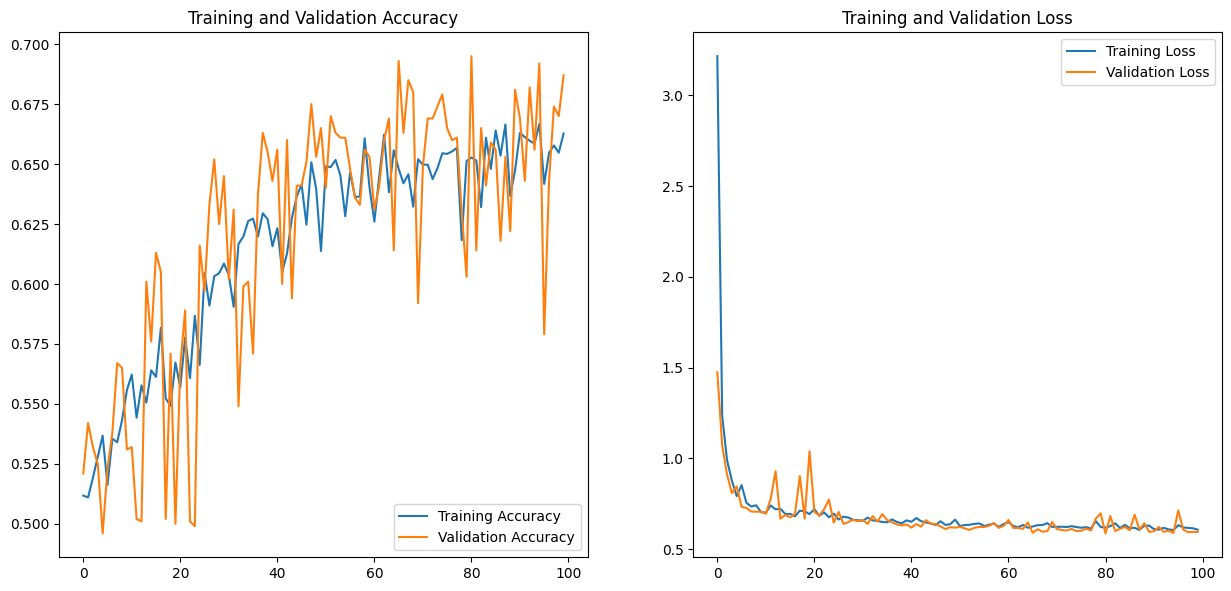

In [11]:
import matplotlib.pyplot as plt

epochs_range = range(EPOCHS)
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, history['Train Acc'], label='Training Accuracy')
plt.plot(epochs_range, history['Val Acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, history['Train Loss'], label='Training Loss')
plt.plot(epochs_range, history['Val Loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
_, criterion = model.get_optim()
loss, acc = model.validate(criterion)
print("\nLoss:", loss)
print("Accuracy:", acc)

Validation: 100%|██████████| 32/32 [00:00<00:00, 63.20batch/s]


Loss: 0.595219574868679
Accuracy: 0.688
